In [1]:
%matplotlib inline

import sys
sys.path.append("../../ee595")
sys.path.append("../../IntegratedGradients")

import numpy as np
from deepsea import *

import seaborn as sns
import matplotlib.pyplot as plt

from IntegratedGradients import integrated_gradients
from keras.models import load_model

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


In [2]:
# data loading

test_X, test_Y = loaddata("../../ee595/data/deepsea/", "test")
train_X, train_Y = loaddata("../../ee595/data/deepsea/", "train")
valid_X, valid_Y = loaddata("../../ee595/data/deepsea/", "valid")

In [3]:
# get sample positions

temp = [i.rstrip().split("\t") for i in open("../data/allTFs.pos.bed").readlines()]
positions = [[i[0], int(i[1]), int(i[2]), i[3], i[4], i[5]] for i in temp]

In [4]:
# divide them into test valid train sets. 

trainpos = positions[0:2200000]
validpos = positions[2200000:2204000]
testpos = [i for i in positions[2204000:] if i[0] == "chr8" or i[0] == "chr9"]

In [49]:
# get which outputnode maps to GM12878, CTCF

description = [i.split("\t")[2] + "_in_" + i.split("\t")[1]for i in open("../../ee595/data/deepsea/features.txt").readlines()[1:-1]]
print description[2], "with index 2"

CTCF_in_GM12878 with index 2


In [50]:
# hg 19 contigs

names = ["chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17_ctg5_hap1",
 "chr17","chr18","chr19","chr1","chr20","chr21","chr22","chr2","chr3","chr4_ctg9_hap1",
 "chr4","chr5","chr6_apd_hap1","chr6_cox_hap2","chr6_dbb_hap3","chr6","chr6_mann_hap4",
 "chr6_mcf_hap5","chr6_qbl_hap6","chr6_ssto_hap7","chr7","chr8","chr9","chrM","chrUn_gl000211",
 "chrUn_gl000212","chrUn_gl000213","chrUn_gl000214","chrUn_gl000215","chrUn_gl000216","chrUn_gl000217",
 "chrUn_gl000218","chrUn_gl000219","chrUn_gl000220","chrUn_gl000221","chrUn_gl000222","chrUn_gl000223",
 "chrUn_gl000224","chrUn_gl000225","chrUn_gl000226","chrUn_gl000227","chrUn_gl000228","chrUn_gl000229",
 "chrUn_gl000230","chrUn_gl000231","chrUn_gl000232","chrUn_gl000233","chrUn_gl000234","chrUn_gl000235",
 "chrUn_gl000236","chrUn_gl000237","chrUn_gl000238","chrUn_gl000239","chrUn_gl000240","chrUn_gl000241",
 "chrUn_gl000242","chrUn_gl000243","chrUn_gl000244",
 "chrUn_gl000245","chrUn_gl000246","chrUn_gl000247","chrUn_gl000248","chrUn_gl000249","chrX","chrY"]

sizes = [135534747,135006516,133851895,115169878,107349540,102531392,90354753,1680828,81195210,78077248,
         59128983,249250621,63025520,48129895,51304566,243199373,198022430,590426,191154276,180915260,4622290,
         4795371,4610396,171115067,4683263,4833398,4611984,4928567,159138663,146364022,141213431,16571,166566,
         186858,164239,137718,172545,172294,172149,161147,179198,161802,155397,186861,180455,179693,211173,15008,
         128374,129120,19913,43691,27386,40652,45941,40531,34474,41934,45867,39939,33824,41933,42152,43523,43341,
         39929,36651,38154,36422,39786,38502,155270560,59373566]

contigs = dict([(names[i], sizes[i]) for i in range(len(sizes))])

In [6]:
index = [i for i in range(2200000) if train_Y[i, 2] == 1]

In [28]:
def loadarray(fileprefix, size):
    index = np.genfromtxt(fileprefix+"_index.csv", dtype=int)
    values = np.genfromtxt(fileprefix+"_values.csv", dtype=int)
    ret = np.zeros(size)
    for i in range(len(index)):
        ret[index[i]-1] = values[i]
    return ret

In [39]:
chroms = list(set([i[0] for i in positions]))

In [41]:
#Loading ATACseq read starts (hyperbolilc arcsine transformation)

atacdata = {}
chrommax = {}
for c in chroms:
    temp = np.arcsinh(loadarray("ATACdata/"+c, contigs[c]))
    atacdata[c] = temp
    chrommax[c] = np.max(temp)
    print np.max(temp)

9.90048304603
9.22345402086
9.58520881083
9.29999825227
10.3017266167
6.03548715579
9.90338755004
5.95584408099
3.68950386899
9.1027551737
5.2040368753
9.53213397931
5.087634437
7.61677605089
7.49108790494
10.0301202054
9.20633236066
11.0353411752
9.04522986583
9.71619365775
9.91689724188
10.5334286579
6.21060410919
10.3040741143


In [36]:
atactrain = [] 
for i in trainpos:
    temp = atacdata[i[0]][i[1]-400:i[2]+400]
    if temp.shape[0] != 1000:
        print i[1]-400, i[2]+400, i[0]
        sample = np.zeros((1000, 1))
        for j in range(len(temp)):
            sample[j,0] = temp[j]
    else:
        sample =  temp.reshape((1000,1))
        
    sample = sample/chrommax[i[0]]
    #sample = np.concatenate([sub1,sub2], axis=1)
    atactrain.append(sub2)
atactrain = np.array(atactrain)

81194400 81195400 chr17
81194600 81195600 chr17


In [42]:
atacvalid = [] 
for i in validpos:
    temp = atacdata[i[0]][i[1]-400:i[2]+400]
    if temp.shape[0] != 1000:
        print i[1]-400, i[2]+400, i[0]
        sample = np.zeros((1000, 1))
        for j in range(len(temp)):
            sample[j,0] = temp[j]
    else:
        sample =  temp.reshape((1000,1))
        
    sample = sample/chrommax[i[0]]
    atacvalid.append(sub2)
atacvalid = np.array(atacvalid)

In [45]:
testvalid = [] 
for i in testpos:
    temp = atacdata[i[0]][i[1]-400:i[2]+400]
    if temp.shape[0] != 1000:
        print i[1]-400, i[2]+400, i[0]
        sample = np.zeros((1000, 1))
        for j in range(len(temp)):
            sample[j,0] = temp[j]
    else:
        sample =  temp.reshape((1000,1))
        
    sample = sample/chrommax[i[0]]
    testvalid.append(sub2)
testvalid = np.array(testvalid)

In [38]:
np.save("atactrain", atactrain)

In [43]:
np.save("atacvalid", atacvalid)

In [47]:
np.save("testvalid", testvalid)

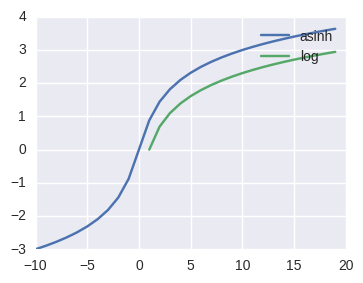

In [65]:
# Sample distribution of asinh and log transformation 

plt.figure(figsize=(4,3))
m = 20
plt.plot(range(-10, m), np.arcsinh(range(-10, m)), label="asinh")
plt.plot(range(-10, m), np.log(range(-10, m)), label="log")
plt.legend()

# visualization

In [11]:
ig = integrated_gradients(dsmodel, [2], verbose=0)

chr1
chr1
chr11
chr11
chr11
chr11
chr11
chr2
chr2
chr3
chr4
chr4
chr4
chr5
chr6


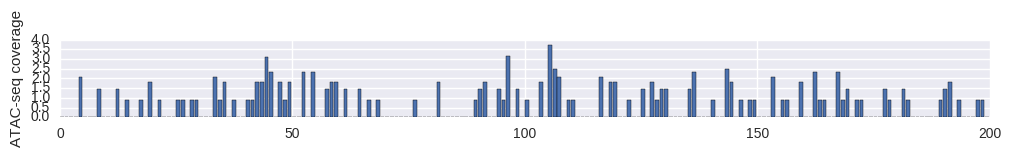

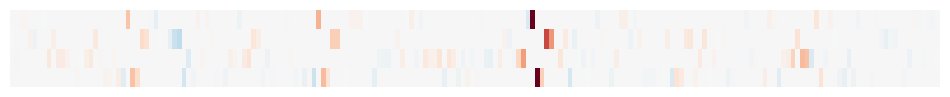

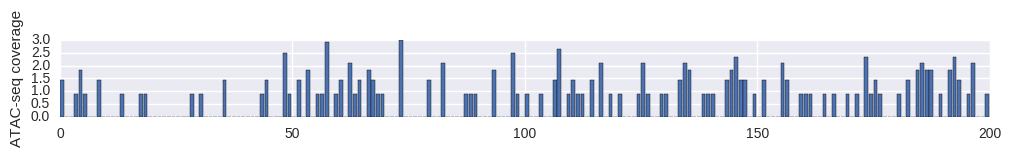

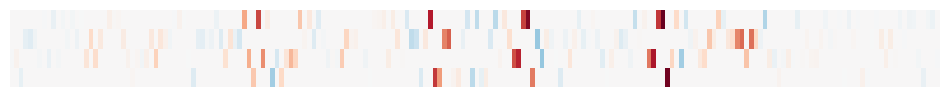

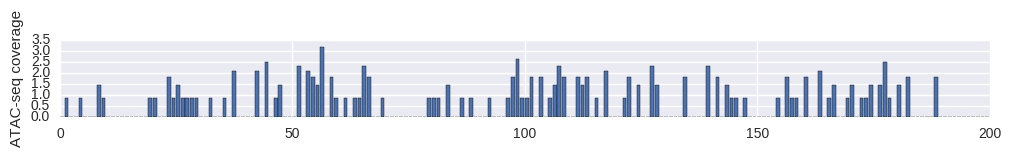

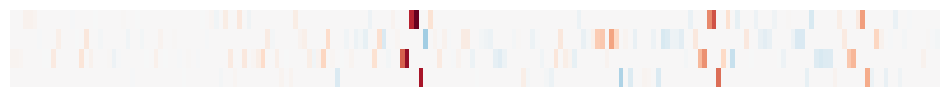

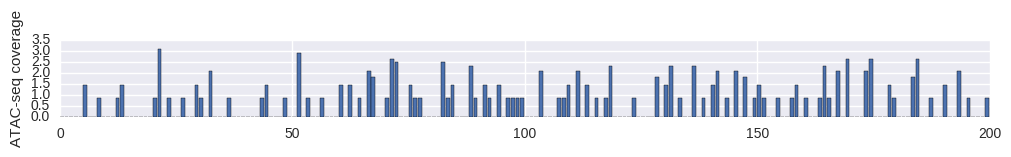

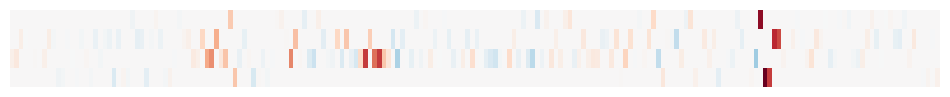

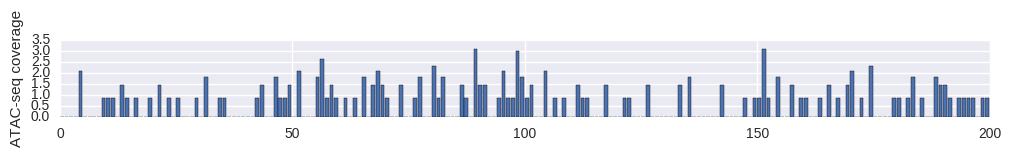

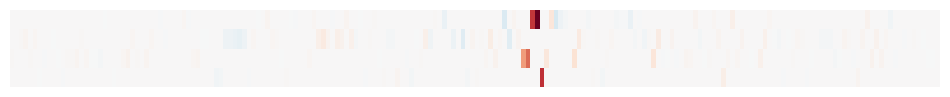

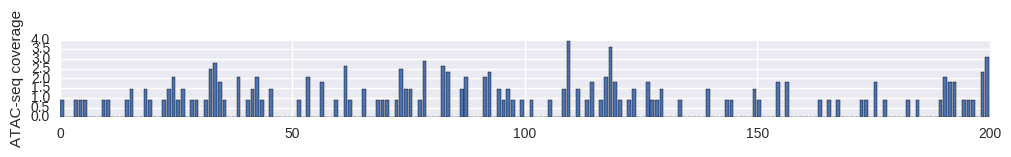

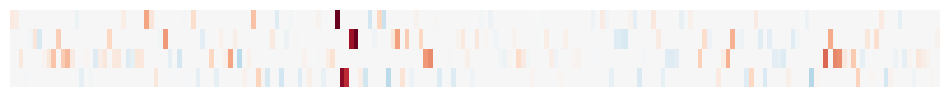

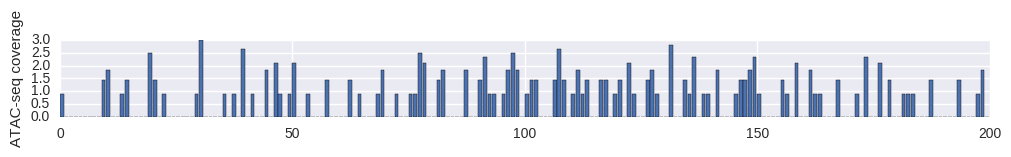

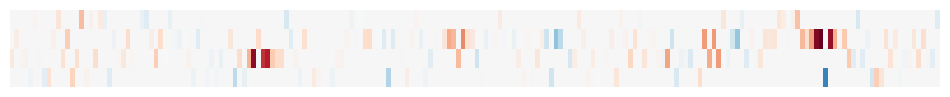

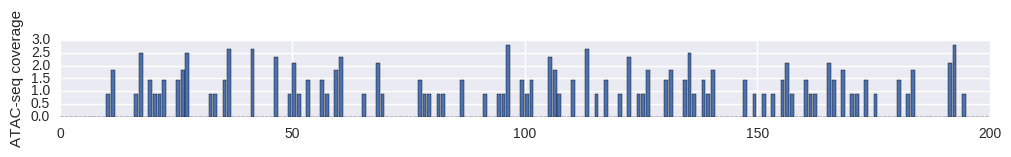

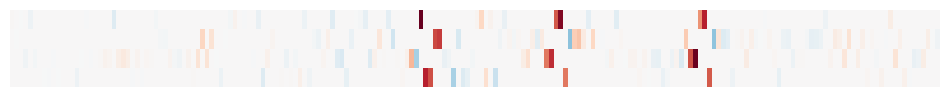

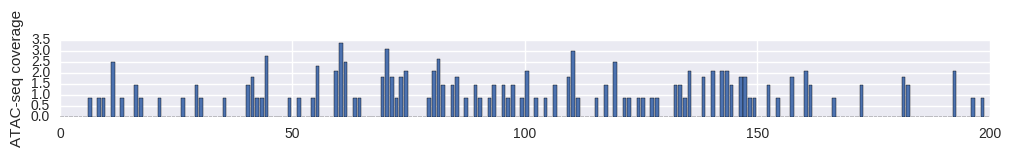

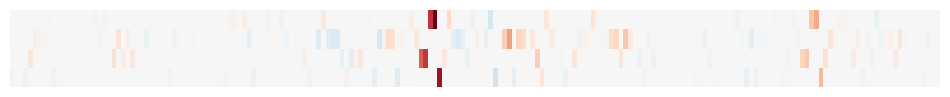

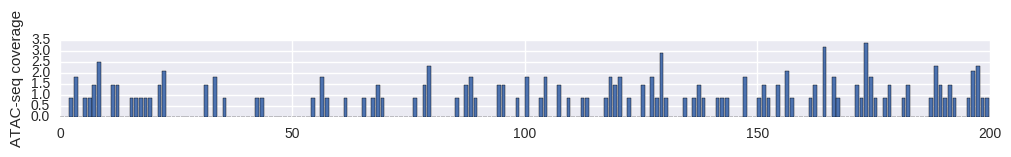

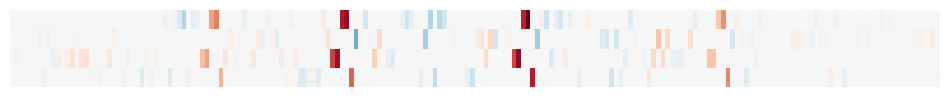

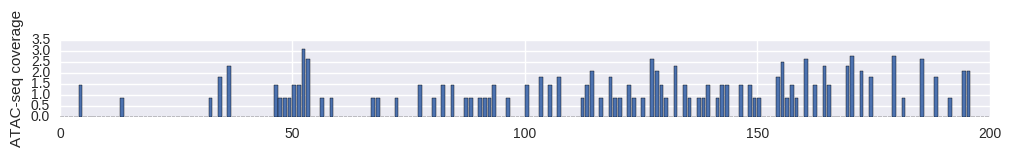

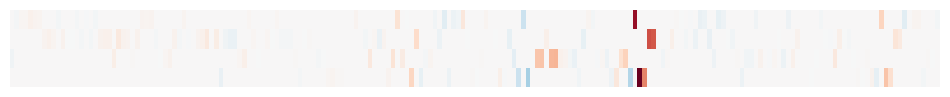

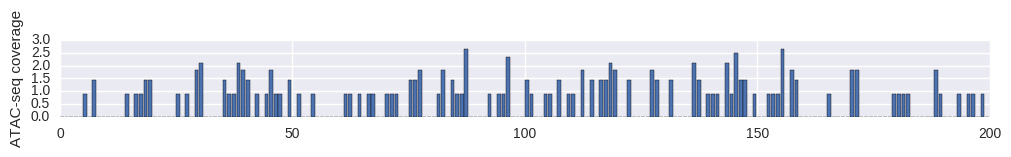

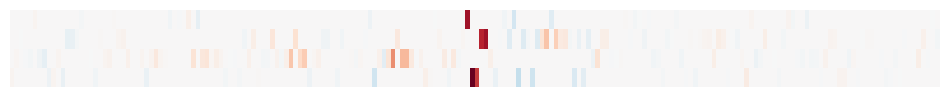

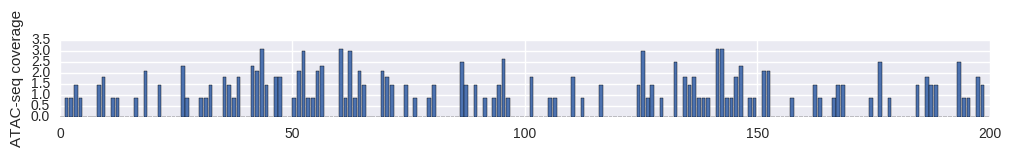

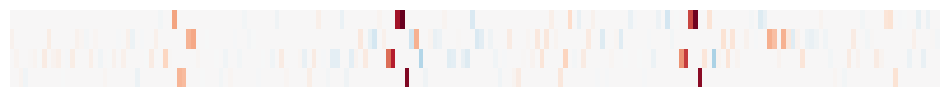

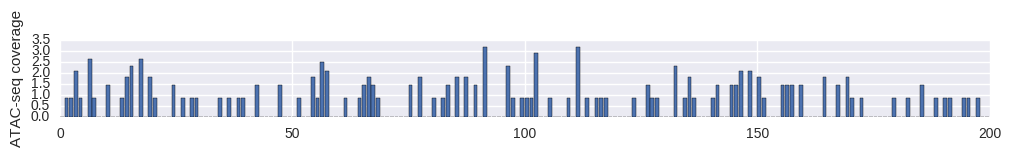

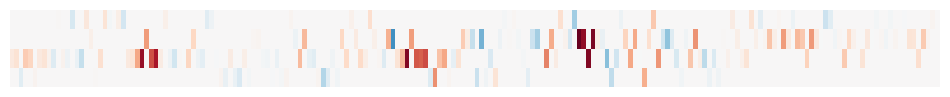

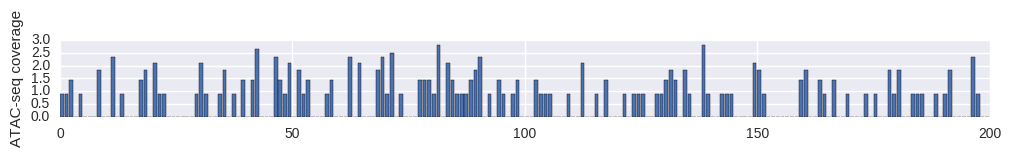

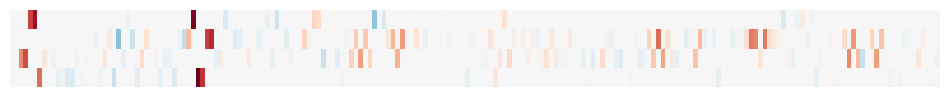

In [63]:
for i in index:
    pos = trainpos[i]
    if sum(atacdata[pos[0]][pos[1]:pos[2]]) > 115:
        print pos[0]
        plt.figure(figsize=(12,1))
        plt.ylabel("ATAC-seq coverage")
        plt.bar(range(200), atacdata[pos[0]][pos[1]:pos[2]])
        ex = ig.explain(train_X[i])[0][400:600]
        plt.figure(figsize=(12,1))
        sns.heatmap(np.transpose(ex), cbar=False)
        plt.yticks([],[])
        plt.xticks([],[])